# Automated DDoS Attack Detection in SDN

## 1. Importing Libraries

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
import numpy as numpy
import pandas as pd , scipy, numpy as np 
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split,KFold
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt
from sklearn import datasets, linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense, LSTM, RNN, GRU 
from keras.layers.core import Dropout, Activation, Flatten, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D, Convolution2D, MaxPooling2D
from keras import layers
import keras
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')


## 2. Dataset
The dataset used for this project: [DDoS Attack SDN Dataset](https://data.mendeley.com/datasets/jxpfjc64kr/1)  
This dataset is SDN-specific and has been generated using `mininet` emulator.

In [ ]:
df=pd.read_csv('dataset_sdn.csv')
df.head()

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,1943,13535,14428310,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,1943,13531,14424046,451,0,UDP,4,3842,3520,0,0.0,0.0,0
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,1,3795,1242,0,0.0,0.0,0
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,2,3688,1492,0,0.0,0.0,0
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,UDP,3,3413,3665,0,0.0,0.0,0


## 3. Data Pre-Processing

In [ ]:
to_drop = ['dt']
df = df.drop(to_drop, axis='columns')
df = df[df['pktrate'] !=0]

In [ ]:
df['src'] = [int(i.split('.')[3]) for i in df['src']]#extracting the last two digits 
df['dst'] = [int(i.split('.')[3])for i in df['dst']]#extracting the last two digits
df['switch'] = df['switch'].astype(str) 
df['src'] = df['src'].astype(str)
df['dst'] = df['dst'].astype(str)
df['port_no'] = df['port_no'].astype(str)
df['Protocol'] = df['Protocol'].astype(str)

In [ ]:
new_df = pd.get_dummies(df,columns = ['switch','src','Protocol','dst','port_no'])
new_df

,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label,switch_1,switch_10,switch_2,switch_3,switch_4,switch_5,switch_6,switch_7,switch_8,switch_9,src_1,src_10,src_11,src_12,src_13,src_14,src_15,src_16,src_17,src_18,src_2,src_20,src_3,src_4,src_5,src_6,src_7,src_8,src_9,Protocol_ICMP,Protocol_TCP,Protocol_UDP,dst_1,dst_10,dst_11,dst_12,dst_13,dst_14,dst_15,dst_16,dst_17,dst_18,dst_2,dst_3,dst_4,dst_5,dst_6,dst_7,dst_8,dst_9,port_no_1,port_no_2,port_no_3,port_no_4,port_no_5
0,45304,48294064,100,716000000,1.010000e+11,3,1943,13535,14428310,451,0,143928631,3917,0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1,126395,134737070,280,734000000,2.810000e+11,2,1943,13531,14424046,451,0,3842,3520,0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,3795,1242,0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,3688,1492,0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,3413,3665,0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104130,910,89180,931,540000000,9.320000e+11,5,3443,30,2940,1,0,5904,1702,0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
104131,910,89180,931,540000000,9.320000e+11,5,3443,30,2940,1,0,134890224,2290,0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
104342,31,3038,31,805000000,3.180500e+10,5,10,30,2940,1,0,3409,3731,0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
104343,31,3038,31,805000000,3.180500e+10,5,10,30,2940,1,0,15209,12720,1,1.0,2.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0


In [ ]:
df.isnull().sum()

switch           0
src              0
dst              0
pktcount         0
bytecount        0
dur              0
dur_nsec         0
tot_dur          0
flows            0
packetins        0
pktperflow       0
byteperflow      0
pktrate          0
Pairflow         0
Protocol         0
port_no          0
tx_bytes         0
rx_bytes         0
tx_kbps          0
rx_kbps        463
tot_kbps       463
label            0
dtype: int64

In [ ]:
new_df.fillna(new_df.mean(), inplace=True)

## 4. Preparing Training and Testing Sets

In [ ]:
x=new_df.drop(['label'],axis=1)
y=new_df.label
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=5)
new_df

,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label,switch_1,switch_10,switch_2,switch_3,switch_4,switch_5,switch_6,switch_7,switch_8,switch_9,src_1,src_10,src_11,src_12,src_13,src_14,src_15,src_16,src_17,src_18,src_2,src_20,src_3,src_4,src_5,src_6,src_7,src_8,src_9,Protocol_ICMP,Protocol_TCP,Protocol_UDP,dst_1,dst_10,dst_11,dst_12,dst_13,dst_14,dst_15,dst_16,dst_17,dst_18,dst_2,dst_3,dst_4,dst_5,dst_6,dst_7,dst_8,dst_9,port_no_1,port_no_2,port_no_3,port_no_4,port_no_5
0,45304,48294064,100,716000000,1.010000e+11,3,1943,13535,14428310,451,0,143928631,3917,0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1,126395,134737070,280,734000000,2.810000e+11,2,1943,13531,14424046,451,0,3842,3520,0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,3795,1242,0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
3,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,3688,1492,0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
4,90333,96294978,200,744000000,2.010000e+11,3,1943,13534,14427244,451,0,3413,3665,0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104130,910,89180,931,540000000,9.320000e+11,5,3443,30,2940,1,0,5904,1702,0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
104131,910,89180,931,540000000,9.320000e+11,5,3443,30,2940,1,0,134890224,2290,0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
104342,31,3038,31,805000000,3.180500e+10,5,10,30,2940,1,0,3409,3731,0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
104343,31,3038,31,805000000,3.180500e+10,5,10,30,2940,1,0,15209,12720,1,1.0,2.0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0


In [ ]:
from sklearn.preprocessing import StandardScaler
scalar=StandardScaler()
x_train=scalar.fit_transform(x_train)
x_test=scalar.transform(x_test)

### Model Analysis Function

In [ ]:
def show_confusion_matrix(model,data,label,pred_label):
  class_names=['Normal','Attack']

  print(plot_confusion_matrix(model, data,label,display_labels=class_names,cmap=plt.cm.Blues,normalize='true'))
  plt.title('Confusion Matrix Logistic Regression')
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  print('\n')
  print(classification_report(label, pred_label))
  print(confusion_matrix(label,pred_label))
  print('\n')

## 5. Classification
We now train our ML models to predict whether the traffic is malicious (labelled as "1") or benign (labelled as "0").  
For classification, we have used 7 different types of classifiers, viz. **Gaussian Naive Bayes (GNB)**, **Logistic Regression (LR)**, **Support Vector Classifier (SVC)**, **Ensemble Classifier (GBC)**, **Decision Tree (DT)**, **Artificial Neural Network (ANN)** , **Deep Learning (LSTM)**

### Gaussian Naive Bayes(GNB)

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
gnb = GaussianNB()

gnb.fit(x_train, y_train.values.ravel())
y_test_pred_gnb = gnb.predict(x_test)

GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
print("Train score is:", gnb.score(x_train, y_train))
print("Test score is:", gnb.score(x_test, y_test))

Train score is: 0.7103458483398293
Test score is: 0.7041178792264176




              precision    recall  f1-score   support

           0       0.70      0.76      0.73      8076
           1       0.70      0.64      0.67      7126

    accuracy                           0.70     15202
   macro avg       0.70      0.70      0.70     15202
weighted avg       0.70      0.70      0.70     15202

[[6161 1915]
 [2583 4543]]




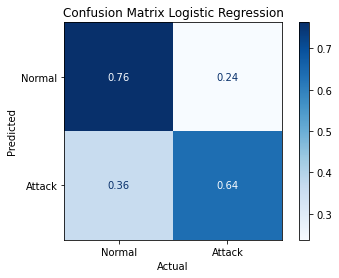

In [ ]:
show_confusion_matrix(gnb,x_test,y_test,y_test_pred_gnb)

### Logistic Regression (LR)

In [ ]:
lr = LogisticRegression(solver='liblinear',multi_class='ovr')
lr.fit(x_train, y_train) 
y_pred_lr = lr.predict(x_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
print("Train score is:", lr.score(x_train, y_train))
print("Test score is:", lr.score(x_test, y_test))

Train score is: 0.8406597924581052
Test score is: 0.8419286935929483




              precision    recall  f1-score   support

           0       0.84      0.86      0.85      8076
           1       0.84      0.82      0.83      7126

    accuracy                           0.84     15202
   macro avg       0.84      0.84      0.84     15202
weighted avg       0.84      0.84      0.84     15202

[[6955 1121]
 [1282 5844]]




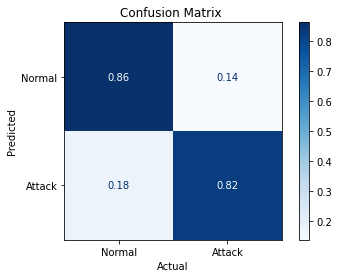

In [ ]:
show_confusion_matrix(lr,x_test,y_test,y_pred_lr)

### Support Vector Classifier (SVC)

In [ ]:
svc = SVC(gamma='auto')
svc.fit(x_train, y_train) 
y_pred_svc = svc.predict(x_test)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
print("Train score is:", svc.score(x_train, y_train))
print("Test score is:", svc.score(x_test, y_test))

Train score is: 0.9790484648149061
Test score is: 0.9762531245888699




              precision    recall  f1-score   support

           0       0.98      0.98      0.98      8076
           1       0.97      0.98      0.97      7126

    accuracy                           0.98     15202
   macro avg       0.98      0.98      0.98     15202
weighted avg       0.98      0.98      0.98     15202

[[7889  187]
 [ 174 6952]]




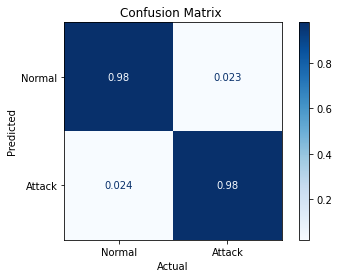

In [ ]:
show_confusion_matrix(svc,x_test,y_test,y_pred_svc)

### Ensemble Classifier (GBC)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
  
gbc = GradientBoostingClassifier()
gbc.fit(x_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
y_pred_gbc = gbc.predict(x_test)

In [ ]:
print("Train score is:", gbc.score(x_train, y_train))
print("Test score is:", gbc.score(x_test, y_test))

Train score is: 0.9977305244461986
Test score is: 0.9965793974477043




              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8076
           1       1.00      1.00      1.00      7126

    accuracy                           1.00     15202
   macro avg       1.00      1.00      1.00     15202
weighted avg       1.00      1.00      1.00     15202

[[8052   24]
 [  28 7098]]




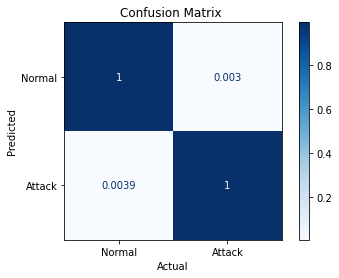

In [ ]:
show_confusion_matrix(gbc,x_test,y_test,y_pred_gbc)

### Decision Tree (DT)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
from sklearn.model_selection import GridSearchCV
folds = KFold(n_splits = 2, shuffle = True, random_state = 10)

hyper_params = [ {'criterion' : ['gini', 'entropy'],
                     'max_depth': [None,1,2,3,4,5]}]


# specify model
model = DecisionTreeClassifier()

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(x_train, y_train)

# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    5.5s finished


GridSearchCV(cv=KFold(n_splits=2, random_state=10, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,0.366050,0.011583,0.012962,0.000139,gini,None,"{'criterion': 'gini', 'max_depth': None}",0.999803,0.999967,0.999885,0.000082,2,1.000000,1.000000,1.000000,0.000000
1,0.104057,0.000105,0.010916,0.000006,gini,1,"{'criterion': 'gini', 'max_depth': 1}",0.742238,0.738907,0.740573,0.001665,11,0.740651,0.741514,0.741082,0.000432
2,0.142136,0.012258,0.010975,0.000297,gini,2,"{'criterion': 'gini', 'max_depth': 2}",0.867024,0.868664,0.867844,0.000820,9,0.871493,0.864459,0.867976,0.003517
3,0.186382,0.006024,0.014463,0.000906,gini,3,"{'criterion': 'gini', 'max_depth': 3}",0.886594,0.883498,0.885046,0.001548,7,0.887478,0.885311,0.886395,0.001084
4,0.217925,0.017915,0.011769,0.000360,gini,4,"{'criterion': 'gini', 'max_depth': 4}",0.928694,0.926060,0.927377,0.001317,6,0.928001,0.926358,0.927179,0.000821
5,0.234847,0.013391,0.011726,0.000141,gini,5,"{'criterion': 'gini', 'max_depth': 5}",0.963788,0.955432,0.959610,0.004178,4,0.965135,0.957703,0.961419,0.003716
6,0.281282,0.002622,0.012315,0.000099,entropy,None,"{'criterion': 'entropy', 'max_depth': None}",0.999770,1.000000,0.999885,0.000115,1,1.000000,1.000000,1.000000,0.000000
7,0.112899,0.004676,0.010780,0.000018,entropy,1,"{'criterion': 'entropy', 'max_depth': 1}",0.741514,0.738907,0.740211,0.001303,12,0.738907,0.741514,0.740211,0.001303
8,0.152115,0.000766,0.011707,0.001034,entropy,2,"{'criterion': 'entropy', 'max_depth': 2}",0.846402,0.850706,0.848554,0.002152,10,0.849850,0.847290,0.848570,0.001280
9,0.188691,0.005257,0.011653,0.000126,entropy,3,"{'criterion': 'entropy', 'max_depth': 3}",0.871892,0.873927,0.872909,0.001018,8,0.873434,0.872122,0.872778,0.000656


In [ ]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.9998848835679516 corresponding to hyperparameters {'criterion': 'entropy', 'max_depth': None}


In [ ]:
dtree = DecisionTreeClassifier()
dtree.fit(x_train, y_train)
# use the model to make predictions with the test data
y_pred = dtree.predict(x_test)
# how did our model perform?
count_misclassified = (y_test != y_pred).sum()
print('Misclassified samples: {}'.format(count_misclassified))
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}'.format(accuracy))

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Misclassified samples: 0
Accuracy: 1.00


In [ ]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[8035    0]
 [   0 7167]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8035
           1       1.00      1.00      1.00      7167

    accuracy                           1.00     15202
   macro avg       1.00      1.00      1.00     15202
weighted avg       1.00      1.00      1.00     15202



In [ ]:
x.columns

Index(['pktcount', 'bytecount', 'dur', 'dur_nsec', 'tot_dur', 'flows',
       'packetins', 'pktperflow', 'byteperflow', 'pktrate', 'Pairflow',
       'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps', 'tot_kbps', 'switch_1',
       'switch_10', 'switch_2', 'switch_3', 'switch_4', 'switch_5', 'switch_6',
       'switch_7', 'switch_8', 'switch_9', 'src_1', 'src_10', 'src_11',
       'src_12', 'src_13', 'src_14', 'src_15', 'src_16', 'src_17', 'src_18',
       'src_2', 'src_20', 'src_3', 'src_4', 'src_5', 'src_6', 'src_7', 'src_8',
       'src_9', 'Protocol_ICMP', 'Protocol_TCP', 'Protocol_UDP', 'dst_1',
       'dst_10', 'dst_11', 'dst_12', 'dst_13', 'dst_14', 'dst_15', 'dst_16',
       'dst_17', 'dst_18', 'dst_2', 'dst_3', 'dst_4', 'dst_5', 'dst_6',
       'dst_7', 'dst_8', 'dst_9', 'port_no_1', 'port_no_2', 'port_no_3',
       'port_no_4', 'port_no_5'],
      dtype='object')

In [ ]:
from sklearn import tree

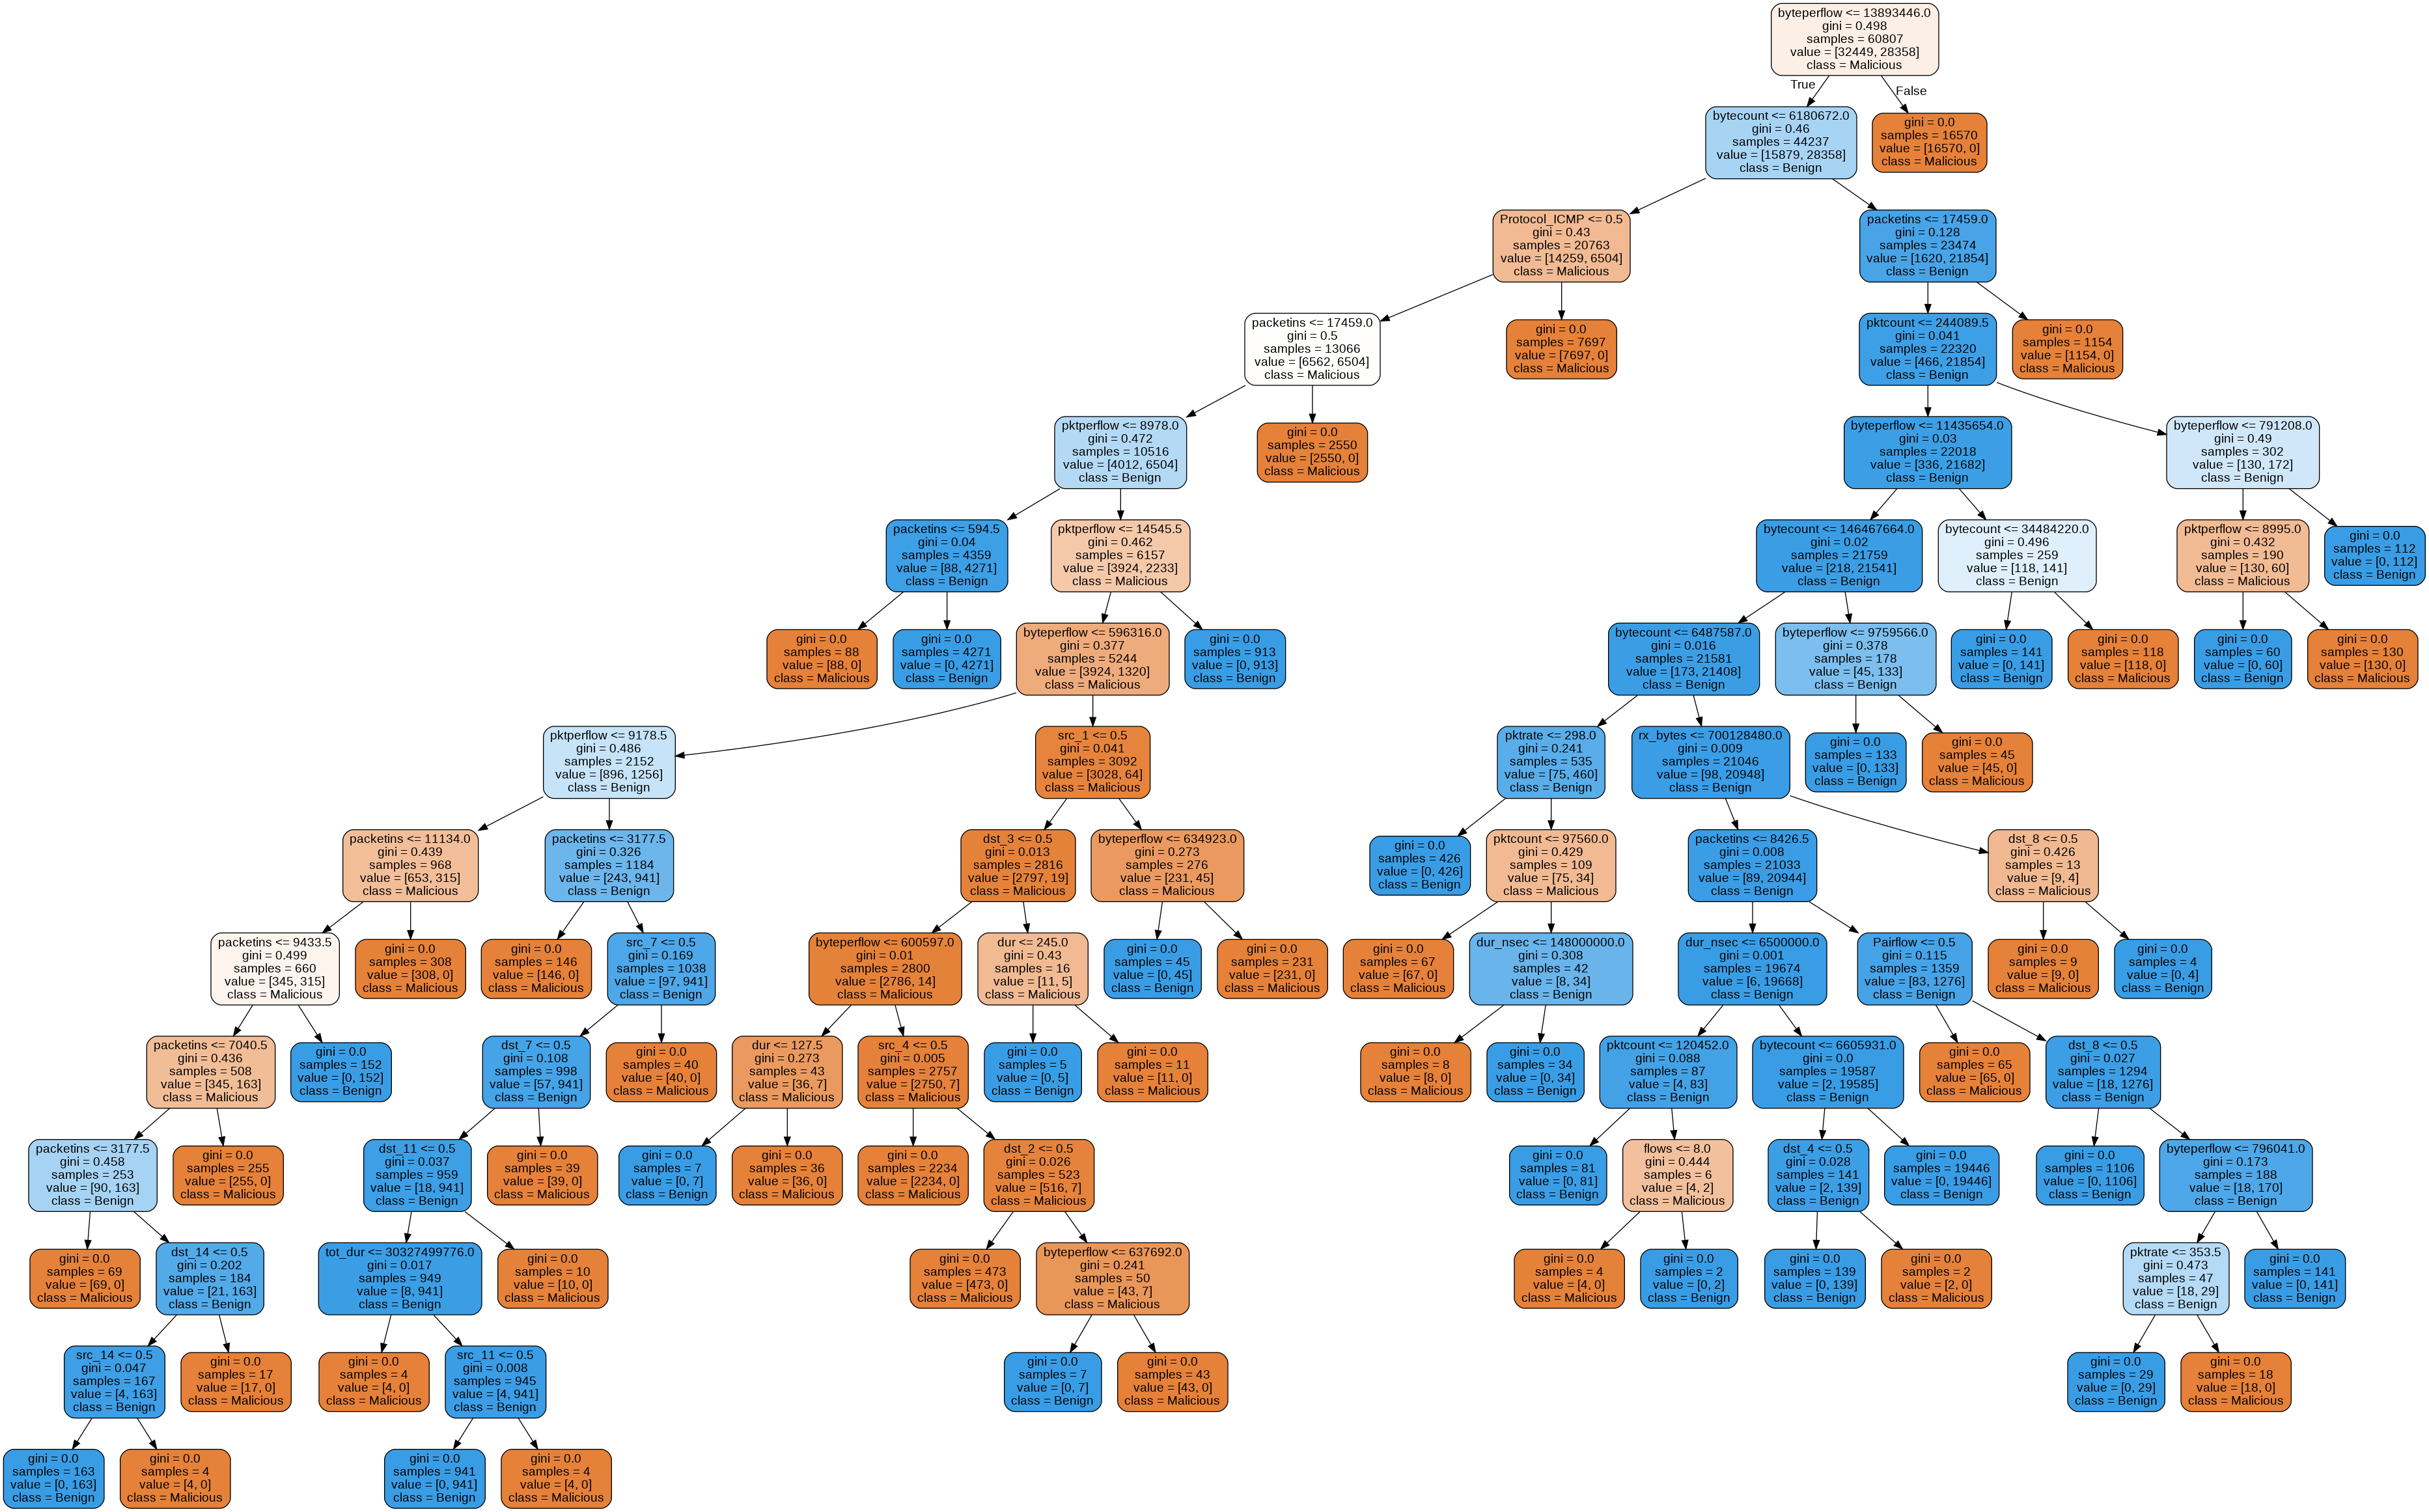

In [ ]:
from IPython.display import Image, display
import matplotlib.pyplot as plt, pydotplus
dot_data = tree.export_graphviz(dtree, out_file=None, filled=True, rounded=True,
                                feature_names=['pktcount', 'bytecount', 'dur', 'dur_nsec', 'tot_dur', 'flows',
       'packetins', 'pktperflow', 'byteperflow', 'pktrate', 'Pairflow',
       'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps', 'tot_kbps', 'switch_1',
       'switch_10', 'switch_2', 'switch_3', 'switch_4', 'switch_5', 'switch_6',
       'switch_7', 'switch_8', 'switch_9', 'src_1', 'src_10', 'src_11',
       'src_12', 'src_13', 'src_14', 'src_15', 'src_16', 'src_17', 'src_18',
       'src_2', 'src_20', 'src_3', 'src_4', 'src_5', 'src_6', 'src_7', 'src_8',
       'src_9', 'Protocol_ICMP', 'Protocol_TCP', 'Protocol_UDP', 'dst_1',
       'dst_10', 'dst_11', 'dst_12', 'dst_13', 'dst_14', 'dst_15', 'dst_16',
       'dst_17', 'dst_18', 'dst_2', 'dst_3', 'dst_4', 'dst_5', 'dst_6',
       'dst_7', 'dst_8', 'dst_9', 'port_no_1', 'port_no_2', 'port_no_3',
       'port_no_4', 'port_no_5'],  
                                class_names=['Malicious','Benign'])
graph = pydotplus.graph_from_dot_data(dot_data)  
display(Image(graph.create_png()))

### Artificial Neural Network (ANN)

In [ ]:
dense_1 = Dense(25,activation = 'tanh')
dense_2 = Dense(8,activation = 'selu')
dense_3 = Dense(25,activation = 'tanh')

inputs = Input(shape = (71,))
dense_x1 = dense_1(inputs)
dense_x2 = dense_2(dense_x1)
dense_x3 = dense_3(dense_x2)
outputs = Dense(1,activation = 'linear',name = 'reconstruction')(dense_x3)

model_ann = Model(inputs = inputs,outputs = outputs)


filepath = "best_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
model_ann.compile(optimizer = 'adam',loss = 'mse',metrics = ['accuracy'],)
model_ann.summary()

history = model_ann.fit(x_train,y_train,epochs = 50,batch_size = 400,callbacks = callbacks_list,validation_data=(x_test, y_test),verbose=1) 


Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 71)]              0         
_________________________________________________________________
dense_56 (Dense)             (None, 25)                1800      
_________________________________________________________________
dense_57 (Dense)             (None, 8)                 208       
_________________________________________________________________
dense_58 (Dense)             (None, 25)                225       
_________________________________________________________________
reconstruction (Dense)       (None, 1)                 26        
Total params: 2,259
Trainable params: 2,259
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
153/153 [==============================] - 1s 2ms/step - loss: 0.2048 - accuracy: 0.7467
Epoch 2/50
153/153 [==

In [ ]:
model_ann.evaluate(x_test,y_test)

476/476 [==============================] - 1s 1ms/step - loss: 0.0051 - accuracy: 0.9948


[0.005143669433891773, 0.9948033094406128]

In [ ]:
predict = model_ann.predict(x_test)
predict= np.round(predict)
print(confusion_matrix(y_test, predict))
print(classification_report(y_test, predict))

[[8033   43]
 [  36 7090]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      8076
           1       0.99      0.99      0.99      7126

    accuracy                           0.99     15202
   macro avg       0.99      0.99      0.99     15202
weighted avg       0.99      0.99      0.99     15202



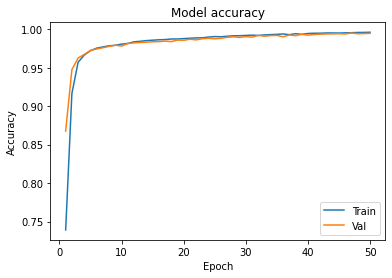

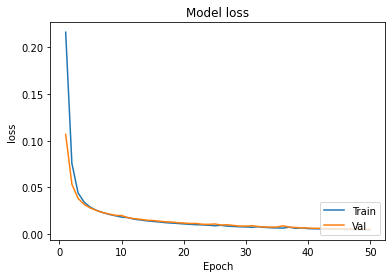

In [ ]:
epochs=50
def plot_learningCurve(history,epochs):
    #Plot training and validation accuracy values
    epochs_range=range(1,epochs+1)
    plt.plot(epochs_range,history.history['accuracy'])
    plt.plot(epochs_range,history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Val'],loc='lower right')
    plt.show()
    #Plot training and validation loss values
    plt.plot(epochs_range,history.history['loss'])
    plt.plot(epochs_range,history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Val'],loc='lower right')
    plt.show()
plot_learningCurve(history,epochs)

### Deep Learning (LSTM)

In [ ]:
x_train=x_train.reshape(60807, 71, 1)
x_test=x_test.reshape(15202, 71, 1)

In [ ]:
print('Build model...')
model = Sequential()
model.add(LSTM(80, return_sequences=False, input_shape=(71,1)))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation('sigmoid'))

Build model...


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
history=model.fit(x_train, y_train, epochs = 20, batch_size=64,validation_data=(x_test, y_test),verbose=1)

Epoch 1/20
951/951 [==============================] - 100s 104ms/step - loss: 0.6408 - acc: 0.6117 - val_loss: 0.4645 - val_acc: 0.7886
Epoch 2/20
951/951 [==============================] - 55s 58ms/step - loss: 0.3350 - acc: 0.8601 - val_loss: 0.2310 - val_acc: 0.9116
Epoch 3/20
951/951 [==============================] - 55s 58ms/step - loss: 0.2078 - acc: 0.9188 - val_loss: 0.2729 - val_acc: 0.8959
Epoch 4/20
951/951 [==============================] - 55s 58ms/step - loss: 0.1822 - acc: 0.9282 - val_loss: 0.1468 - val_acc: 0.9438
Epoch 5/20
951/951 [==============================] - 55s 58ms/step - loss: 0.1486 - acc: 0.9414 - val_loss: 0.1242 - val_acc: 0.9535
Epoch 6/20
951/951 [==============================] - 55s 58ms/step - loss: 0.1225 - acc: 0.9517 - val_loss: 0.0909 - val_acc: 0.9654
Epoch 7/20
951/951 [==============================] - 57s 60ms/step - loss: 0.1028 - acc: 0.9604 - val_loss: 0.0864 - val_acc: 0.9655
Epoch 8/20
951/951 [==============================] - 57s 60

In [ ]:
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

476/476 [==============================] - 6s 13ms/step - loss: 0.0264 - acc: 0.9901
Accuracy: 99.01%


In [ ]:
y_pred = model.predict(x_test)
predict= np.round(y_pred)
confusion_matrix(y_test,predict)
print('\n')
print(classification_report(y_test,predict))

array([[8021,   55],
       [  95, 7031]])



              precision    recall  f1-score   support

           0       0.99      0.99      0.99      8076
           1       0.99      0.99      0.99      7126

    accuracy                           0.99     15202
   macro avg       0.99      0.99      0.99     15202
weighted avg       0.99      0.99      0.99     15202



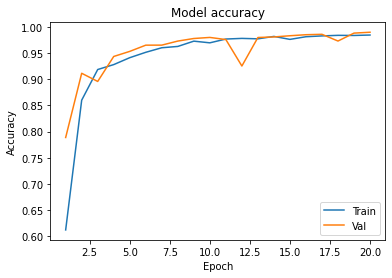

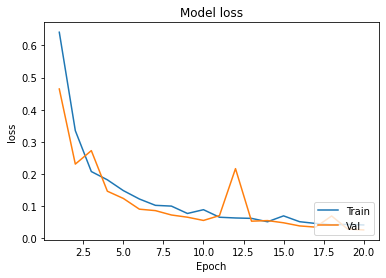

In [ ]:
epochs=20
def plot_learningCurve(history,epochs):
    #Plot training and validation accuracy values
    epochs_range=range(1,epochs+1)
    plt.plot(epochs_range,history.history['acc'])
    plt.plot(epochs_range,history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Val'],loc='lower right')
    plt.show()
    #Plot training and validation loss values
    plt.plot(epochs_range,history.history['loss'])
    plt.plot(epochs_range,history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Val'],loc='lower right')
    plt.show()
plot_learningCurve(history,epochs)

## 6. Analysis

In [2]:
from tabulate import tabulate 
print('N:Normal ')
print('A:Attack')
headers = ('Algo ','Acc','N Prec','A Prec','N Rec','A Rec','N F-score','A F-score','FPR','FNR')
data1 = ['GNB',0.70,0.70,0.70,0.76,0.64,0.73,0.67,0.24,0.36]
data2 = ['LR',0.84,0.84,0.84,0.86,0.82,0.85,0.83,0.14,0.18]
data3 = ['SVC',0.98,0.98,0.97,0.98,0.98,0.98,0.97,0.023,0.024]
data4 = ['Ensemble',0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.001,0.001]
data5 = ['DT',1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,0]
data6 = ['ANN',0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.001,0.001]
data7 = ['DL',0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.001,0.001]

data = [data1, data2, data3, data4, data5,data6,data7]
print(tabulate(data, headers=headers, tablefmt='grid'))

N:Normal 
A:Attack
+----------+-------+----------+----------+---------+---------+-------------+-------------+-------+-------+
| Algo     |   Acc |   N Prec |   A Prec |   N Rec |   A Rec |   N F-score |   A F-score |   FPR |   FNR |
+==========+=======+==========+==========+=========+=========+=============+=============+=======+=======+
| GNB      |  0.7  |     0.7  |     0.7  |    0.76 |    0.64 |        0.73 |        0.67 | 0.24  | 0.36  |
+----------+-------+----------+----------+---------+---------+-------------+-------------+-------+-------+
| LR       |  0.84 |     0.84 |     0.84 |    0.86 |    0.82 |        0.85 |        0.83 | 0.14  | 0.18  |
+----------+-------+----------+----------+---------+---------+-------------+-------------+-------+-------+
| SVC      |  0.98 |     0.98 |     0.97 |    0.98 |    0.98 |        0.98 |        0.97 | 0.023 | 0.024 |
+----------+-------+----------+----------+---------+---------+-------------+-------------+-------+-------+
| Ensemble |  0.99

<Figure size 600x600 with 0 Axes>

Text(0.5, 0, '1-Specificity-->')

Text(0, 0.5, 'Sensitivity-->')

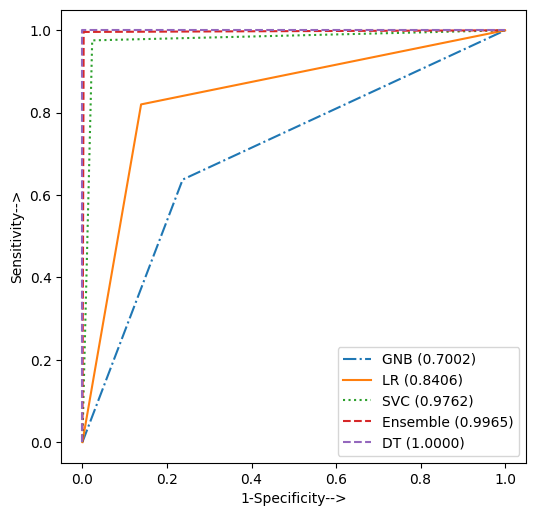

In [ ]:
l_fpr, l_tpr, threshold1 = roc_curve(y_test, y_pred_lr)
g_fpr, g_tpr, threshold2 = roc_curve(y_test, y_test_pred_gnb)
e_fpr, e_tpr, threshold3 = roc_curve(y_test, y_pred_gbc)
s_fpr, s_tpr, threshold4 = roc_curve(y_test, y_pred_svc)
d_fpr, d_tpr, threshold4 = roc_curve(y_test, y_pred_dt)


auc_l = auc(l_fpr, l_tpr)
auc_s = auc(s_fpr, s_tpr)
auc_g = auc(g_fpr, g_tpr)
auc_e = auc(e_fpr, e_tpr)
auc_d = auc(d_fpr, d_tpr)


plt.figure(figsize=(6,6), dpi=100)
plt.plot(g_fpr, g_tpr, linestyle='-.', label='GNB (%.4f)' %auc_g)
plt.plot(l_fpr, l_tpr, linestyle='-', label='LR (%.4f)' %auc_l)
plt.plot(s_fpr, s_tpr, linestyle=':', label='SVC (%.4f)' %auc_s)
plt.plot(e_fpr, e_tpr, linestyle='--', label='Ensemble (%.4f)' %auc_e)
plt.plot(d_fpr, d_tpr, linestyle='--', label='DT (%.4f)' %auc_d)

plt.xlabel('1-Specificity-->')
plt.ylabel('Sensitivity-->')
plt.legend()

plt.show()